# 2.1: Ill-posedness and regularisation - X-ray tomography #

*Andrew Valentine & Malcolm Sambridge - Research School of Earth Sciences, The Australian National University - Last updated Sept. 2019*

In this practical, we will look at inverse problems that are linear, but under-determined: some model parameters may be unconstrained, and regularisation is required to ensure that a stable solution can be found.

As an example, we will consider performing X-Ray Tomography (XRT) to image the interior of a structure. We assume that the x-rays travel at the same speed regardless of the medium through which they are passing, and so their paths are straight lines between source and receiver. However, the medium causes the x-rays to attenuate: paths through dense objects (such as bones!) arrive at the receiver with far less energy than they had at the source. Thus, by analysing the attenuation along many different paths, we can build up a picture of the interior of an object.

Specifically, we will assume that the intensity at the receiver, $I_{rec}$, is related to the intensity at the source, $I_{src}$ by $$I_{rec} = I_{src}\exp\left\{-\int_\mathrm{path} \mu(\mathbf{x})\,\mathrm{d}\mathbf{l}\right\}$$ where $\mu(\mathbf{x})$ is a position-dependent attenuation coefficient. To obtain a linear inverse problem, we rewrite this as $$-\log \frac{I_{rec}}{I_{src}}=\int_\mathrm{path} \mu(\mathbf{x})\,\mathrm{d}\mathbf{l}\,.$$ We know that $$\int\left[f(x) + g(x)\right]\,\mathrm{d}x = \int f(x)\,\mathrm{d}x + \int g(x)\,\mathrm{d}x$$ so we say that integration is a *linear* operation, and hence we can solve the XRT problem with linear inverse theory. 

We will assume that the object we are interested in is 2-dimensional, so that $\mu(\boldsymbol{x}) = \mu(x,y)$. If we discretize this model, with $N_x$ cells in the $x$-direction and $N_y$ cells in the $y$-direction, we can express $\mu(x,y)$ as an $N_x \times N_y$ vector $\boldsymbol{\mu}$. This is related to the data by
$$d_i = A_{ij}\mu_j $$
where $d_i = -\log {I^{(i)}_{rec}}/{I^{(i)}_{src}}$, and where $A_{ij}$ represents the path length in cell $j$ of the discretized model.

The module `inversionCourse.xrayTomography` implements this forward problem and provides some other functions that will be useful during this practical.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from anu_inversion_course import xrayTomography as xrt

The main function we will use is `xrt.tracer()`, which computes $\int_\mathrm{path} \mu(x,y) \,\mathrm{d}\mathbf{l}$. It is called as follows:
```python
attns, A = xrt.tracer(model, paths)
```
where:
- `model` is the discretized version of $\mu(x,y)$. This is expressed as an array of dimension $(N_x,N_y)$.
- `paths` is an array of source and receiver locations. This has dimension $(N_{paths},4)$, so that
    - `paths[i,0]` - $x$-location of source for path $i$
    - `paths[i,1]` - $y$-location of source for path $i$
    - `paths[i,2]` - $x$-location of receiver for path $i$
    - `paths[i,3]` - $y$-location of receiver for path $i$
- `attns` is the attenuation for each path. It is an array of dimension $(N_{paths})$, with `attns[i]` being equivalent to $d_i$ in the description above.
- `A` is the matrix relating model to data. It has dimension $(N_{paths}, N_x\cdot N_y)$, with `A[i,j]` being equivalent to $A_{ij}$ above.

By default, we assume that the model is defined within the region $0\le x \le 1$ and $0\le y\le 1$. This can be changed by specifying an additional argument to `xrt.tracer`, `extent=(xmin,xmax,ymin,ymax)`. Note that all sources and receivers must lie within, or on the boundary of, this model region.

For example,

In [2]:
model = np.ones([3,3])
model[1,1] = 2
model[0,2] = 1.5
paths = np.array([[0,0.5,1,0.9],
                  [0,0.5,0.8,0]])
attns, A = xrt.tracer(model,paths)

Evaluating paths: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1953.11it/s]


To plot models, you can use the function `xrt.displayModel`. This takes the form:
```python
xrt.displayModel(model,paths,extent,clim,cmap,figsize)
```
but only the first argument is essential; the others are all optional. Their meanings are:
- `model` is the 2-D array containg the attenuation coefficients in each cell
- `paths` is the 2-D array of path information in the same form as for `xrt.tracer`. We recommend you do not use this option if you have more than a modest number of paths (a few tens) as it will be slow to plot and difficult to see anything useful.
- `extent` specifies the region of space for which the model is defined, in the format `(xmin,xmax,ymin,ymax)`; by default this is `(0,1,0,1)` as for `xrt.tracer`.
- `clim` sets the range of the colour-scale; use `clim=(min,max)`. By default this is inferred from the model provided.
- `cmap` sets the colour map; provide one of the many choices provided within `matplotlib` (accessed within `plt.cm`, e.g. `cmap=plt.cm.RdBu_r`)
- `figsize` allows you to control the size of the figure: provide `figsize=(xsize,ysize)`.

For example,

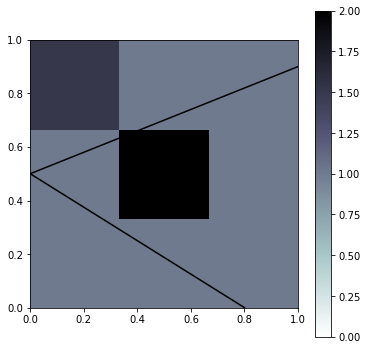

In [3]:
xrt.displayModel(model,paths=paths,clim=(0,2))

We can also look at the matrix `A` returned by `xrt.tracer`. Plotting the whole matrix may appear uninformative,

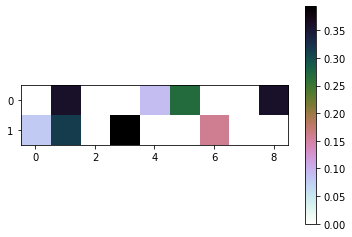

In [4]:
plt.imshow(A,cmap=plt.cm.cubehelix_r)
plt.colorbar()

but we know that each row should somehow correspond to the path-length in each grid cell. We can see this by using `xrt.displayModel` to plot a single row (note that we set the upper limit of the colour-scale to be equal to the diagonal size of a single grid-cell):

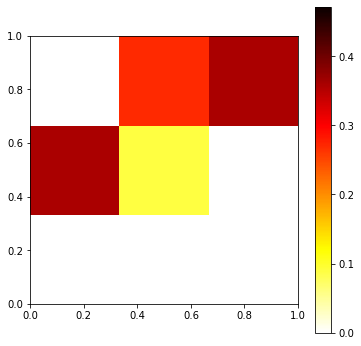

In [5]:
xrt.displayModel(A[0,:].reshape([3,3]),cmap=plt.cm.hot_r,clim=(0,np.sqrt(2)/3.))

This shows us which grid cells - and hence, which model parameters - can be constrained using the first data point.

**Task 1:** Convince yourself that you understand how to use `xrt.tracer()`.

In [6]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 



The file `xrt_data.dat` contains a large dataset collected during an X-Ray tomography experiment; we want to use it to construct a model for the object. The data table contains the following information:
- Source location $(x,y)$
- Source intensity
- Receiver location $(x,y)$
- Received intensity
and the first few lines are:
```text
# Src-x Src-y Src-Int Rec-x Rec-y Rec-Int
0.0000 0.0323 5.9987 1.0000 0.0323 2.0570
0.0000 0.0323 6.3879 1.0000 0.0645 2.1543
0.0000 0.0323 1.8923 1.0000 0.0968 0.6279
```
You can read this file straightforwardly by using `dataset = np.loadtxt('Datasets/xrt_data.dat')`. Then, `dataset[i,:]` will contain the six pieces of information for the $i$-th path.

**Task 2:** Read in the dataset and convert it into a format suitable for performing the tomographic inversion.

In [7]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 



Our next task is to obtain the matrix `A` required for the inverse problem. We need to run `xrt.tracer`, but how can we do this without knowing the model? Fortunately, `A` depends only on the paths and not on the model structure, so we simply need to provide a 'dummy' model array of the desired dimensions. But what should these be? We don't know anything about the object we're trying to image, so we must guess a 'reasonable' size. This is a tradeoff between resolution (too few cells means we won't see any detail) and computational costs. 


**Task 3:** Obtain the sensitivity matrix for the inverse problem. 

*Hint:* We suggest you begin by using
`model = np.ones([50,50])`.

In [8]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 



We can now solve the inverse problem using the Tikhonov-regularised form of least-squares,
$$\mathbf{m}=\left(\mathbf{A^TA}+\epsilon^2\mathbf{I}\right)^\mathbf{-1}\mathbf{A^Td}$$

**Task 4:** Write a function to solve the inverse problem. It will probably look something like:
```python
def solveInverseProblem(A,d,epsSquared):
    [...]
    m = ...
    return m
```

*Hint:* Remember, you can make an identity matrix of dimension $N$ by calling `np.eye(N)`.


In [9]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 



Finally, we can use this function to invert our dataset. You will notice that your function returns a vector, whereas our models are expressed as a 2-D grid. In order to plot results, you will need to use `np.reshape`, e.g.:
```python
m = solveInverseProblem(A,d,epsSquared)
xrt.displayModel(m.reshape([nx,ny]))
```

**Task 5:** Invert the XRT dataset provided and plot the results. 

*Hint:* For this dataset, a good initial choice is $\epsilon^2 = 0.001$. 

In [10]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 



**Task 6:** Investigate how your results change as you vary:
- The dimensions of the model (N.B. a model of dimension $N_x\times N_y$ requires a matrix of dimension $N_xN_y \times N_xN_y$ to be inverted. Don't make this too big, or your computer will probably get unhappy!);
- The regularisation parameter, $\epsilon^2$;
- The noise level on the data (try adding Gaussian random noise to $I_{rec}$ and see how results change).

What happens if you only use a subset of the available data?


In [11]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 



How do you choose a good value for $\epsilon^2$? This isn't an easy question to answer, and there are a lot of different techniques and rules-of-thumb in the literature. One common approach is to plot an 'L-curve', showing how $\|\mathbf{d}-\mathbf{Gm}\|_2^2$ trades off with $\|\mathbf{m}\|_2^2$ as $\epsilon^2$ is varied.

**Task 7:** Plot the $L$-curve for this problem. How do you think this can be used to choose a good value for $\epsilon^2$? Why?

In [12]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 



If you wish to experiment further, you can make your own datasets. The following functions may be helpful:
- `xrt.pngToModel(pngFile,nx,ny,bg,sc)` - Convert any `.png` image file to an array suitable for use in xrt.tracer. The dimensions of the output model are `[nx,ny]`. `bg` and `sc` are used to set a minimum 'background' model value and to rescale the whole model, respectively. They can be omitted if not required.
- `xrt.buildPaths(srcs,recs)` - Given a list of sources and receivers, build an array describing the paths from every source to every receiver, in the format prescribed for `xrt.tracer`.
- `xrt.generateSurfacePoints(nPerSide,extent,surface,addCorners)` - Create a list of points on the surface of the region described by `extent`. This list is suitable for passing to `xrt.buildPaths` as source or receiver coordinates. `nPerSide` specifies the number of points on a single side of the region; `extent=(xmin,xmax,ymin,ymax)` describes the region's extent. `surface` is a list, e.g. `[True, False, True, True]` defining which sides should receive points; the order is left, right, bottom, top. `addCorners=True/False` determines whether points should also be placed at the corners of the region.

In [13]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

